# GENERALISED SIDELOBE CANCELLER

Esse Jupyter tem como objetivo implementar o algoritmo do GSC.

In [1]:
import librosa
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import pandas as pd
from random import uniform
from os import listdir
from IPython.display import Audio

In [2]:
#DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {'figure.figsize': [7, 4], 
          'axes.labelsize': 12,
          'axes.titlesize':16, 
          'font.size': 12,
          'legend.fontsize': 12, 
          'xtick.labelsize': 10, 
          'ytick.labelsize': 10
         }

plt.rcParams.update(params)

## Definição de Funções

Abaixo, a já conhecida verificarDelay, que retorna o número de amostras de defasagem entre dois sinais.

In [3]:
def verificarDelay(sinalA, sinalB, maxDelay=25):
    
    # Verificando se os dois sinais tem o mesmo tamanho e se maxDelay é compatível
    if len(sinalA) != len(sinalB) or maxDelay >= len(sinalA)-1 :
        return False
    
    # Sei que o maior delay possível (em qtd de amostras) é maxDelay. Portanto, em cada iteração, 
    # a comparação entre os sinais para gerar a correlação se dará com arrays de tamanho 
    # len(sinal) - maxDelay
    tamanho = len(sinalA) - maxDelay
    
    # O delay será a qtd de amostras pra trás ou para frente que há
    # entre o sinal B em relação ao sinal A. Negativo significa que B está adiantado, 0 que não há
    # delay e positivo que está atrasado.
    delay = 0
    melhorCorrelacao = -1
    
    inicioA = 0
    fimA    = inicioA + tamanho
    inicioB = len(sinalB) - tamanho
    fimB    = inicioB + tamanho
    
    # Fazendo as iterações e calculando a correlação entre os sinais
    for i in range(-maxDelay, maxDelay+1):
        
        # Calculando a correlação da iteração atual
        corrAtual = np.corrcoef(sinalA[inicioA:fimA], sinalB[inicioB:fimB])[0][1]
        
        # Verificando se encontramos uma correlacao maior ainda para atualizar o delay
        if corrAtual > melhorCorrelacao:
            melhorCorrelacao = corrAtual
            delay = -i
            
        # Fazendo os indexes dos arrays da próxima iteração. De i = -maxDelay até 0, o Sinal A 
        # fica parado e o Sinal B vem vindo pra trás. A partir de i = 1 até maxDelay, o Sinal B
        # fica parado e o Sinal A vai embora.
        if i < 0:
            inicioB -= 1
            fimB     = inicioB + tamanho
        else:
            inicioA += 1
            fimA     = inicioA + tamanho
    
    # Retornando o delay
    return delay

Abaixo, a função beamforming, que receberá os sinais dos microfones e o delay entre cada um deles. A função então irá defasar os sinais de forma que o beamforming seja feito.

In [4]:
def beamforming(vetorSinais, vetorDelays):
    # O VETOR DE DELAYS TAMBEM PRECISA TER O DELAY00
    
    # SINAL QUE VAI CONTER TODOS OS OUTROS SOMADOS
    sinalFinal = np.zeros(len(vetorSinais[0]))
    
    # PARA CADA SINAL
    for index, sinalAtual in enumerate(vetorSinais):
        
        # DELAY ENTRE O SINAL ATUAL E O SINAL 0
        delayAtual = vetorDelays[index]
        
        # SE FOR POSITIVO, EU COMO UMA PARTE DO SINAL NO COMECO E PREENCHO COM ZEROS NO FINAL
        if delayAtual >= 0:
            vetorSinais[index] = np.concatenate((sinalAtual[delayAtual:], np.zeros(delayAtual)))
            
        # SE FOR NEGATIVO, EU COLOCO ZEROS NO COMECO E CORTO DO FINAL
        else:
            vetorSinais[index] = np.concatenate((np.zeros(-delayAtual), sinalAtual[:delayAtual]))
            
        # POR ULTIMO, EU SOMO O SINAL ATUAL NO SINAL FINAL
        sinalFinal += sinalAtual
            
    # NO FINAL
    return sinalFinal, vetorSinais

Função para gerar uma Blocking Matrix

Dimensão da matriz: qtdMicrofones-1 x qtdMicrofones

https://drive.google.com/drive/folders/1d_B72P3emyTU_1Z1_3ry5KqWh5PqaJdO 2001_Book_MicrophoneArrays Página 34

In [5]:
def gerarBlockingMatrix(qtdMics):
    
    # INICIANDO A MATRIZ COM ZEROS
    blockingMatrix = np.zeros((qtdMics-1, qtdMics))
    
    for cont, linha in enumerate(blockingMatrix):
        linha[cont]   = 1
        linha[cont+1] = -1
    
    return blockingMatrix

Função para calcular a energia de um sinal:

In [6]:
def energiaSinal(sinal):
    return sum(sinal**2)

## Aplicando o GSC

### Importando os sinais dos microfones

A gravação que será utilizada já foi somada com um ruído branco no Audacity. Com o efeito do GSC, espera-se que o ruído diminua.

Abrindo os sinais dos microfones:

In [7]:
diretorio = '/home/dimi/Programming/IC2019/DOA/Gravacoes/GSC/Gravacao1/'

sinalMic0, freqAmostragem = librosa.load(diretorio + 'mic-01.wav', sr=None, mono=True)
sinalMic1, freqAmostragem = librosa.load(diretorio + 'mic-02.wav', sr=None, mono=True)
sinalMic2, freqAmostragem = librosa.load(diretorio + 'mic-03.wav', sr=None, mono=True)
sinalMic3, freqAmostragem = librosa.load(diretorio + 'mic-04.wav', sr=None, mono=True)
sinalMic4, freqAmostragem = librosa.load(diretorio + 'mic-05.wav', sr=None, mono=True)
sinalMic5, freqAmostragem = librosa.load(diretorio + 'mic-06.wav', sr=None, mono=True)
sinalMic6, freqAmostragem = librosa.load(diretorio + 'mic-07.wav', sr=None, mono=True)
sinalMic7, freqAmostragem = librosa.load(diretorio + 'mic-08.wav', sr=None, mono=True)

arraySinaisOriginais = np.array([
    sinalMic0,
    sinalMic1,
    sinalMic2,
    sinalMic3,
    sinalMic4,
    sinalMic5,
    sinalMic6,
    sinalMic7
])

Verificando como é o sinal original, com ruído:

In [8]:
i = 0
print("Exemplo de um dos sinais dos microfones originais")
Audio(data=arraySinaisOriginais[i], rate=freqAmostragem)

Exemplo de um dos sinais dos microfones originais


Antes de fazer o Beamforming, Blocking Matrix e tal, vou criar o somaSinaisOriginais, que vai ser a soma de todos os microfones do jeito que eles vieram mesmo.

In [9]:
somaSinaisOriginais = np.sum(arraySinaisOriginais, axis=0)
Audio(data=somaSinaisOriginais, rate=freqAmostragem)

### Verificando o delay entre os microfones

Agora, para mandar para a função que fará o beamforming, preciso dos delays entre cada microfone. Para a função beamforming funcionar, TAMBÉM PRECISO DO DELAY ENTRE O MICROFONE 0 E O MICROFONE 0, por isso aquele 0 no começo do array:

In [10]:
arrayDelays = np.array([
    0,
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[1]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[2]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[3]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[4]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[5]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[6]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[7])
])

print(arrayDelays)

[  0  -5   5 -10   2   0   9  -1]


### Visualizando os dados de entrada para o GSC

Os dados de entrada necessários para compor o algoritmo GSC são os sinais dos microfones e os delays entre os microfones.

In [11]:
i = 0

print("O sinal do microfone", i, "possui o seguinte shape:\n", arraySinaisOriginais[i].shape)
print("\n\nSinal do microfone " + str(i) + ":\n", arraySinaisOriginais[i])
print("\n\nEm seguida, o array de delays:\n", arrayDelays)

O sinal do microfone 0 possui o seguinte shape:
 (116716,)


Sinal do microfone 0:
 [-0.18118286 -0.27249146 -0.18688965 ...  0.07220459 -0.01812744
  0.01107788]


Em seguida, o array de delays:
 [  0  -5   5 -10   2   0   9  -1]


### Aplicando o Beamforming

Olhando para os sinais antes do Beamforming:

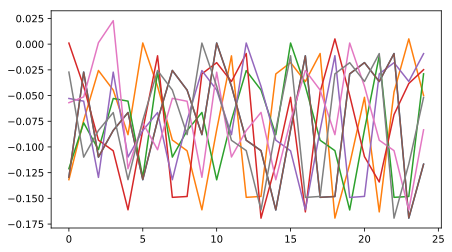

In [12]:
inicio = 50000
fim    = 50025

plt.plot(arraySinaisOriginais[0][inicio:fim])
plt.plot(arraySinaisOriginais[1][inicio:fim])
plt.plot(arraySinaisOriginais[2][inicio:fim])
plt.plot(arraySinaisOriginais[3][inicio:fim])
plt.plot(arraySinaisOriginais[4][inicio:fim])
plt.plot(arraySinaisOriginais[5][inicio:fim])
plt.plot(arraySinaisOriginais[6][inicio:fim])
plt.plot(arraySinaisOriginais[7][inicio:fim])

plt.show()

Agora posso criar uma sinal com a soma de todos os outros defasados:

In [13]:
# APLICANDO O BEAMFORMING
sinalBF, arraySinaisBF = beamforming(arraySinaisOriginais, arrayDelays)

# POR ALGUM MOTIVO O PYTHON ESTA MUDANDO OS SINAIS ORIGINAIS TAMBEM
# POR ISSO, VOU CRIAR O ARRAY DE SINAIS ORIGINAIS DE NOVO
arraySinaisOriginais = np.array([
    sinalMic0,
    sinalMic1,
    sinalMic2,
    sinalMic3,
    sinalMic4,
    sinalMic5,
    sinalMic6,
    sinalMic7
])

print("Áudio após a aplicação do Beamforming:")
Audio(data=sinalBF, rate=freqAmostragem)

Áudio após a aplicação do Beamforming:


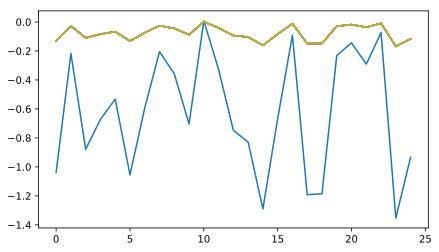

In [14]:
inicio = 50000
fim    = 50025

plt.plot(sinalBF[inicio:fim])
plt.plot(arraySinaisBF[0][inicio:fim])
plt.plot(arraySinaisBF[1][inicio:fim])
plt.plot(arraySinaisBF[2][inicio:fim])
plt.plot(arraySinaisBF[3][inicio:fim])
plt.plot(arraySinaisBF[4][inicio:fim])
plt.plot(arraySinaisBF[5][inicio:fim])
plt.plot(arraySinaisBF[6][inicio:fim])
plt.plot(arraySinaisBF[7][inicio:fim])

plt.show()

### Blocking Matrix

A próxima parte é gerar uma Blocking Matrix

In [15]:
blockingMatrix = gerarBlockingMatrix(qtdMics=8)
print(blockingMatrix)

[[ 1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.]]


Agora, posso fazer a multiplicaçao BM x Sinais. Essa multiplicação vai resultar em um sinal a menos.

In [16]:
arraySinaisBM = np.matmul(blockingMatrix, arraySinaisOriginais)
print("O array de sinais após a Blocking Matrix tem shape:", arraySinaisBM.shape)
print("\nExemplo de sinal após a multiplicação da Blocking Matrix:")

i = 4
Audio(data=arraySinaisBM[i], rate=freqAmostragem)

O array de sinais após a Blocking Matrix tem shape: (7, 116716)

Exemplo de sinal após a multiplicação da Blocking Matrix:


### Teste manual (sem filtragem adaptativa)

Vou fazer a soma dos sinais que restaram após a Blocking Matrix e depois vou multiplicá-los por um fator. O resultado será subtraído do sinal beamformado.

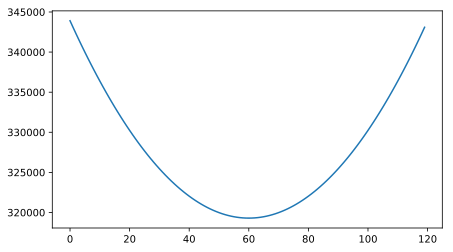

O fator que minimizará a energia do sinal final é: 4.100000000000005


In [17]:
energiasFatores = [9e9]
melhorFator     = 0
somaSinaisAposBM = np.sum(arraySinaisBM, axis=0)

for i, fatorAtual in enumerate(np.arange(-2, 10, 0.1)):
    energiasFatores.append(energiaSinal(sinalBF - fatorAtual*somaSinaisAposBM))
    
    if energiasFatores[i] < energiasFatores[i-1]:
        melhorFator = fatorAtual

plt.plot(energiasFatores[1:])
plt.show()

print("O fator que minimizará a energia do sinal final é:", melhorFator)

In [30]:
fator      = 4.1
sinalFinal = sinalBF - fator*somaSinaisAposBM

print("Energia do sinal original:\t\t", energiaSinal(sinalBF))
print("Energia do sinal após a subtração:\t", energiaSinal(sinalFinal))

Energia do sinal original:		 330235.9351925729
Energia do sinal após a subtração:	 319303.31422347884


In [31]:
print("Áudio Beamformado:")
Audio(data=sinalBF, rate=freqAmostragem)

Áudio Beamformado:


In [20]:
print("Áudio da soma dos sinais após a Blocking Matriz (ruído):")
Audio(data=somaSinaisAposBM, rate=freqAmostragem)

Áudio da soma dos sinais após a Blocking Matriz (ruído):


In [21]:
print("Áudio após a subtração do ruído:")
Audio(data=sinalFinal, rate=freqAmostragem)

Áudio após a subtração do ruído:


# Aplicando o GSC com Algoritmo Genético

Até agora, tenho os seguintes sinais:

__somaSinaisOriginais:__ Soma de cada um dos microfones do jeito que eles vieram, sem fazer beamforming nem nada;

__arraySinaisBF:__ Um array com os sinais originais defasados. Somar os sinais desse array produz o sinal beamformado;

__arraySinaisBM:__ Um array com os sinais que restaram após a Blocking Matrix.

Vou começar a escrever as funções para o algoritmo genético.

### Definição de funções para o algoritmo genético

#### Função para criar um indivíduo aleatório

Cada indivíduo será um array com N-1 posições, sendo N o número de microfones. Isto porque depois da Blocking Matrix, sobra um sinal a menos.

Cada posição será o peso multiplicativo do respectivo sinal após a blocking matrix. Esses pesos serão aleatórios para essa função, afinal, ela só será usada na hora de criar a população inicial. Depois, haverá o crossover.

Sinal Final = Sinal Beamformado - (peso1 * sinal1BM + peso2 * sinal2BM + ... + pesoN-1 * sinalN-1BM)

In [32]:
def criarNovoIndividuo(qtdMics):
    
    individuo = []
    
    for i in range(qtdMics-1):
        individuo.append(uniform(0.0, 15.0))
        
    return np.array(individuo)

In [43]:
individuo = criarNovoIndividuo(8)
print(individuo)

[ 4.3853349   0.50186287 11.17585472  5.27526629  0.78734188  1.49975982
 14.13418657]


#### Função para criar a população inicial

In [33]:
def criarPopulacaoInicial(qtdMics, qtdIndividuos=25):
    
    populacaoInicial = []
    
    for i in range(qtdIndividuos):
        populacaoInicial.append(criarNovoIndividuo(qtdMics))
        
    return np.array(populacaoInicial)

In [53]:
populacao = criarPopulacaoInicial(8, 3)
print(populacao)

[[12.21478663  9.38761743 11.83488141  7.75156085 12.15387646  6.94435042
   8.82055226]
 [14.09396699 11.93346401 14.39800006  9.78940617  7.59124655 12.22675434
   1.91028846]
 [ 6.38391158  4.14871806  4.27992526  0.35485923  9.47770821  9.58590362
   0.21320569]]


#### Função Fitness

O Fitness de cada indivíduo será a energia do sinal após a subtração dos sinais da Blocking Matrix sobre o sinal beamformado.

In [54]:
def fitness(individuo, sinalBF, arraySinaisBM):
    
    sinalRuidos = 0
    
    # SOMANDO CADA UM DOS SINAIS DA BLOCKING MATRIX COM SEU DEVIDO PESO
    for index, peso in enumerate(individuo):
        sinalRuidos += peso * arraySinaisBM[index]
        
    sinalFinal = sinalBF - sinalRuidos
    
    return energiaSinal(sinalFinal)

In [292]:
print(energiaSinal(sinalBF), "\n")
print(fitness(populacao[0], sinalBF, arraySinaisBM))

330235.9351925729 

461752.23986535834


#### Função para calcular o fitness de toda a população

Posteriormente, será necessário ordenar todos os indivíduos na ordem de melhor para o pior fitness para que seja possível selecionar os melhores para reprodução. Ela recebe a população atual e retorna um vetor contendo o respectivo Fitness de cada indivíduo.

In [196]:
# Função que retorna um vetor contendo o fitness de cada individuo na população.
def calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM):
    
    vetorFitness = []
    
    for individuoAtual in populacao:
        vetorFitness.append(fitness(individuoAtual, sinalBF, arraySinaisBM))
        
    return np.array(vetorFitness)

In [251]:
vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM)
print(vetorFitness)

[564303.86053815 362752.53533649 340143.46693615]


#### Função para realizar mutação

Primeiro gero um número aleatório para testar a probabilidade de haver mutação. Caso haja mutação, seleciono aleatoriamente um gene e faço ele ter um novo valor aleatório.

In [208]:
def realizarMutação(individuo, probabilidadeMutacao):
    
    # ROLANDO O DADO PARA VER SE ELE VAI SOFRER MUTAÇÃO OU NÃO
    if uniform(0,1) <= probabilidadeMutacao:
        
        # SE SIM, VOU ESCOLHER UM GENE ALEATORIAMENTE PARA SOFRER A MUTAÇÃO
        geneMutacao = int(uniform(0, len(individuo)))
        individuo[geneMutacao] = uniform(0.0, 15.0)
        
    return individuo

In [229]:
index = 0

print(populacao[index])
populacao[index] = realizarMutação(populacao[index], 1)
print(populacao[index])

[ 1.66694263  9.38761743  2.78344517  9.60123876  7.80057613  6.94435042
 13.19928987]
[ 8.35016892  9.38761743  2.78344517  9.60123876  7.80057613  6.94435042
 13.19928987]


#### Função Crossover

A reprodução dos indivíduos consistirá na média de cada gene.

In [231]:
def crossover(individuoPai, individuoMae, probabilidadeMutacao):
    individuoFilho = (individuoPai + individuoMae)/2
    individuoFilho = realizarMutação(individuoFilho, probabilidadeMutacao)
    return individuoFilho

In [247]:
pai   = populacao[0]
mae   = populacao[1]
filho = crossover(pai, mae, 0)

print(pai, "\n", mae, "\n", filho)

[ 8.35016892  9.38761743  2.78344517  9.60123876  7.80057613  6.94435042
 13.19928987] 
 [14.09396699 11.93346401 14.39800006  9.78940617  7.59124655 12.22675434
  1.91028846] 
 [11.22206795 10.66054072  8.59072262  9.69532247  7.69591134  9.58555238
  7.55478916]


#### Função para ordenar os individuos de acordo com o fitness

A seleção dos melhores indivíduos da população para reprodução depende de que o vetor **populacao** esteja devidamente ordenado do melhor fitness para o pior. A função abaixo ordena o vetor **popualacao** de acordo com o fitness de cada indivíduo. É importante lembrar que **vetorFitness** também será reorganizado para manter o arranjo **indivíduos <-> fitness**.

In [254]:
def ordenarIndividuos(populacao, vetorFitness):
    
    populacao.tolist()
    vetorFitness.tolist()
    
    for i in range(0, len(vetorFitness)):
        for j in range(i+1, len(vetorFitness)):
            if vetorFitness[j] < vetorFitness[i]:
                vetorFitness[i], vetorFitness[j] = vetorFitness[j], vetorFitness[i]
                populacao[[i, j]] = populacao[[j, i]]
            
    return np.array(populacao), np.array(vetorFitness)

In [261]:
populacao    = criarPopulacaoInicial(8, 5)
vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM) 

for i, individuoAtual in enumerate(populacao):
    print("[" + str(individuoAtual[0]) + "]", "\t->\t", vetorFitness[i])
    
populacao, vetorFitness = ordenarIndividuos(populacao, vetorFitness)
print("\n")
    
for i, individuoAtual in enumerate(populacao):
    print("[" + str(individuoAtual[0]) + "]", "\t->\t", vetorFitness[i])

[4.3953464062881835] 	->	 461752.23986535834
[5.627059262443682] 	->	 495984.5451199376
[2.4559543329303883] 	->	 1006796.7152738993
[11.029687494525863] 	->	 694364.3509241822
[14.486157547938795] 	->	 559730.2515192513


[4.3953464062881835] 	->	 461752.23986535834
[5.627059262443682] 	->	 495984.5451199376
[14.486157547938795] 	->	 559730.2515192513
[11.029687494525863] 	->	 694364.3509241822
[2.4559543329303883] 	->	 1006796.7152738993


#### Funções para selecionar os indivíduos pai e mãe para reprodução

A primeira função é responsável por selecionar o **index** do indivíduo que será selecionado de acordo com as probabilidades: 0 -> 50%; 1 -> 25%; 2 -> 12,5% e assim sucessivamente.

A segunda função usa a primeira para selecionar os indivíduos pai e mãe, e garante que eles sejam diferentes.

In [270]:
def selecionarIndexParaReproducao():
    i = 1
    continuar = True
    probabilidade = uniform(0,1)

    while continuar:
        if(probabilidade >= 1/(2 ** i)):
            continuar = False
        else:
            i += 1
    
    return i - 1

In [271]:
def selecionarIndexPaiMae(tamanhoPopulacao):
    
    # SELECIONO UM INDEX PARA O PAI E VERIFICO SE E VALIDO
    indexPai = selecionarIndexParaReproducao()

    while (indexPai > (tamanhoPopulacao - 1)):
        indexPai = selecionarIndexParaReproducao()
    
    # AGORA FACO A MESMA COISA PARA A MAE, LEMBRANDO QUE NAO PODE SER UM INDEX IGUAL AO DO PAI
    indexMae = selecionarIndexParaReproducao()
        
    while (indexMae > (tamanhoPopulacao - 1)) or indexMae == indexPai:
        indexMae = selecionarIndexParaReproducao()

    # AGORA POSSO RETORNAR OS INDEXES
    return indexPai, indexMae

In [285]:
pai, mae = selecionarIndexPaiMae(5)
print(pai, mae)

2 0


#### Função principal que une todas as outras

Essa função será responsável por criar a população inicial, realizar os primeiros cruzamentos e progredir as gerações.

In [286]:
def rodarAlgoritmoGenetico(qtdMics, tamanhoPopulacao, qtdMaxIteracoes, qtdNovosIndividuos, probabilidadeMutacao, sinalBF, arraySinaisBM):
    
    # Vetores que serão usados para plotar dados obtidos
    vetorMediaFitness = []
    vetorMaxFitness = []
    vetorMinFitness = []

    # Criando a população inicial
    populacao = criarPopulacaoInicial(qtdMics, tamanhoPopulacao)

    for i in range(0, qtdMaxIteracoes):
        # Para cada iteração eu calculo o fitness dos indivíduos e ordeno-os de acordo com esse valor
        vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM)
        populacao, vetorFitness = ordenarIndividuos(populacao, vetorFitness)

        # Guardando dados sobre a iteração atual para plotar depois
        vetorMediaFitness.append(np.mean(vetorFitness))
        vetorMaxFitness.append(np.amax(vetorFitness))
        vetorMinFitness.append(np.amin(vetorFitness))

        # Fazendo a reprodução para criar a geração futura
        novaGeracao = []
        for j in range(qtdNovosIndividuos):

            # Indexes da população para escolher os reprodutores
            indexPai, indexMae = selecionarIndexPaiMae(len(populacao)) 

            # Gerando os filhos (a mutação acontece dentro da função crossover, não é necessário realizar a 
            # mutação nessa célula)
            filho = crossover(populacao[indexPai], populacao[indexMae], probabilidadeMutacao)

            # Colocando os filhos na nova geração
            novaGeracao.append(filho)

        # Aqui, irei substituir os piores individuos da geração anterior pelos novos filhos gerados
        # dessa forma, alguns indivíduos da geração anterior irão permanecer para a próxima geração
        populacao = populacao[:len(populacao)-len(novaGeracao)]
        populacao = np.concatenate((populacao, np.array(novaGeracao)), axis=0)
        
    # Agora que acabaram as gerações, vou colocar os indivíduos em ordem pra retornar o melhor
    vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM)
    populacao, vetorFitness = ordenarIndividuos(populacao, vetorFitness)
    
    melhorIndividuoFinal = populacao[0]
    melhorFitnessFinal   = vetorFitness[0] 
    
    return vetorMinFitness, vetorMediaFitness, vetorMaxFitness, melhorIndividuoFinal, melhorFitnessFinal

## Finalmente rodando o algoritmo genético para o GSC

In [309]:
qtdMics = 8
tamanhoPopulacao = 50
qtdNovosIndividuos = 15
probabilidadeMutacao = 0.075
qtdMaxIteracoes = 15

vetorMinFitness, vetorMediaFitness, vetorMaxFitness, melhorIndividuoFinal, melhorFitnessFinal = rodarAlgoritmoGenetico(qtdMics, tamanhoPopulacao, qtdMaxIteracoes, qtdNovosIndividuos, probabilidadeMutacao, sinalBF, arraySinaisBM)

Text(0, 0.5, 'Fitness')

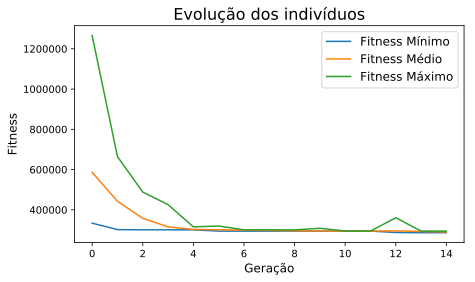

In [310]:
plt.plot(vetorMinFitness, label="Fitness Mínimo")
plt.plot(vetorMediaFitness, label="Fitness Médio")
plt.plot(vetorMaxFitness, label="Fitness Máximo")
plt.legend()
plt.title("Evolução dos indivíduos")
plt.xlabel("Geração")
plt.ylabel("Fitness")

#### Construindo o sinal final a partir dos pesos encontrados

In [311]:
# CONSTRUINDO O SINAL FINAL
sinalRuidos = 0
for index, peso in enumerate(melhorIndividuoFinal):
    sinalRuidos += peso * arraySinaisBM[index]
sinalFinal = sinalBF - sinalRuidos

# VERIFICANDO A MELHORA NA ENERGIA DO SINAL
energiaInicial = energiaSinal(sinalBF)
energiaFinal   = energiaSinal(sinalFinal)

print("Energia inicial:\t", energiaInicial)
print("Energia final:\t\t", energiaFinal)
print("Redução percentual:\t", 1 - energiaFinal/energiaInicial)

Energia inicial:	 330235.9351925729
Energia final:		 285970.81766681426
Redução percentual:	 0.13404088655568624


#### Ouvindo o resultado

In [313]:
print("Áudio original sem beamforming:")
Audio(data=somaSinaisOriginais, rate=freqAmostragem)

Áudio original sem beamforming:


In [314]:
print("Áudio após o beamforming:")
Audio(data=sinalBF, rate=freqAmostragem)

Áudio após o beamforming:


In [315]:
print("Áudio após o GSC completo:")
Audio(data=sinalFinal, rate=freqAmostragem)

Áudio após o GSC completo:


#### Salvando os áudios como WAV

Antes de fazer isso, vou dividir todos os áudios por 8, pois os microfones foram somados e agora esses sinais estão muito altos.

In [317]:
# somaSinaisOriginais = somaSinaisOriginais/8
# sinalBF             = sinalBF/8
# sinalFinal          = sinalFinal/8

librosa.output.write_wav('sinalOriginal.wav', somaSinaisOriginais, freqAmostragem)
librosa.output.write_wav('sinalBeamformado.wav', sinalBF, freqAmostragem)
librosa.output.write_wav('sinalFinal.wav', sinalFinal, freqAmostragem)

In [321]:
print(energiaSinal(somaSinaisOriginais))
print(energiaSinal(sinalBF))
print(energiaSinal(sinalFinal))

70.35520715774624
80.62400761537424
69.81709415693707
